In [1]:
from data_loader import *
import keras
from keras.models import Model, load_model
from keras import backend as K
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"
data_file2 = "/datax/yzhang/training_data/training_data_chunk_13.pkl"

CLASSES = ['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB', 'APSK16_c34',
 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB',
 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE', 'OQPSK', 'PI4QPSK', 'QAM16',
 'QAM32', 'QAM64', 'QPSK']

COLORS = {
    '16PSK': '#FF8800', 
    '2FSK_5KHz': '#3cb44b', 
    '2FSK_75KHz': '#ffe119', 
    '8PSK': '#C2BEA1', 
    'AM_DSB': '#0082c8', 
    'AM_SSB':'#911eb4', 
    'APSK16_c34': '#46f0f0',
    'APSK32_c34': '#f032e6', 
    'BPSK': '#d2f53c', 
    'CPFSK_5KHz': '#fabebe', 
    'CPFSK_75KHz': '#008080', 
    'FM_NB': '#e6beff', 
    'FM_WB': '#aa6e28',
    'GFSK_5KHz': '#fffac8', 
    'GFSK_75KHz': '#800000', 
    'GMSK': '#aaffc3', 
    'MSK': '#808000', 
    'NOISE': '#ffd8b1', 
    'OQPSK': '#000080', 
    'PI4QPSK': '#808080', 
    'QAM16': '#0AC0E0',
    'QAM32': '#000000', 
    'QAM64': '#E00A19', 
    'QPSK': '#3BF703'}




testdata = LoadModRecData(data_file, 1., 0., 0., load_snrs=[10], num_samples_per_key=100)
train_data = testdata.signalData
train_labels = testdata.signalLabels[:,0]


testdata2 = LoadModRecData(data_file2, 1., 0., 0., load_snrs=[10], num_samples_per_key=100)
train_data2 = testdata2.signalData
train_labels2 = testdata2.signalLabels[:,0]

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 2400
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: FM

In [3]:
print(train_data.shape, train_labels.shape)
print(train_data2.shape, train_labels2.shape)

(2400, 2, 1024) (2400,)
(2400, 2, 1024) (2400,)


In [415]:
def tsne_model(model, data, layer_name=None, pca_dim=50, tsne_dim=2):
    """
    Does tsne reduction
    Parameters:
    model (keras model)
    data (np array): input data for the model
    layer_name: name of the output layer to do tsne on. 'None' will use 2nd to last layer, before final dense layer
 
    pca_dim (int): first dimensions are reduced using PCA to this number of dimensions
    tsne_dim (int): final desired dimension after doing tsne reduction
    
    Returns:
    np.array: Shape (data.shape[0], tsne_reduc); sample points in reduced space
    """
    
    if not layer_name:
        layer_name = model.layers[-2].name
    
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    
    intermediate_output = intermediate_layer_model.predict(data)
    
    pca = PCA(n_components= pca_dim, random_state = 214853)
    output_pca_reduced = pca.fit_transform(intermediate_output)
    
    tsne = TSNE(n_components=tsne_dim, random_state=214853)
    intermediates_tsne = tsne.fit_transform(output_pca_reduced)
    return intermediates_tsne


def tsne_plus_plot(model, data, labels, layer_name=None, pca_dim=50, tsne_dim= 2, mode = "train"):
    # calculate tsne and plot scatterplot
    intermediates_tsne = tsne_model(model=model,data=data,layer_name=layer_name,pca_dim=pca_dim,tsne_dim=tsne_dim)
    
    color_intermediates = []
    for label in labels:
        color_intermediates.append(COLORS[label])
    color_intermediates = np.asarray(color_intermediates)
    scatter_plot(intermediates_tsne[:,0], intermediates_tsne[:,1],color_intermediates,labels)
    
def scatter_plot(x, y, c, labels):
    
    unique_labels = np.unique(labels)

    plt.figure(figsize=(16, 16))
    for label in unique_labels:
        marker = 'o'
        if label == "16PSK":
            marker = "<"
        elif label == "8PSK":
            marker = "*"
        elif label == "MSK":
            marker = "x"
        elif label == "FM_NB":
            marker = "s"
        
                
        idx = np.where(labels == label)[0]
#         plt.scatter(intermediates_tsne[idx,0], intermediates_tsne[idx,1], color=color_intermediates[idx], label=label, marker=marker)

        plt.scatter(x[idx],y[idx],color=c[idx], label=label, marker=marker)

    plt.legend()
    plt.show()
    



In [5]:
model = load_model('../../mod_group0_val_loss5754_copy.h5')

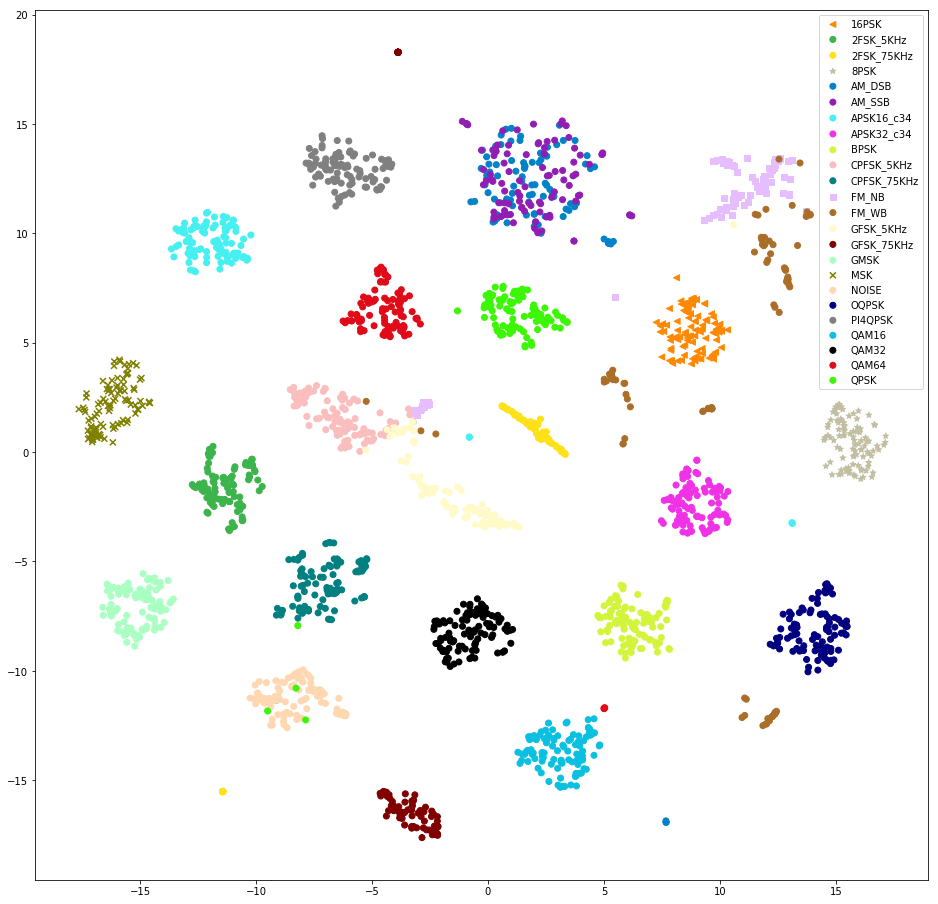

In [417]:
tsne_plus_plot(model, train_data, train_labels)

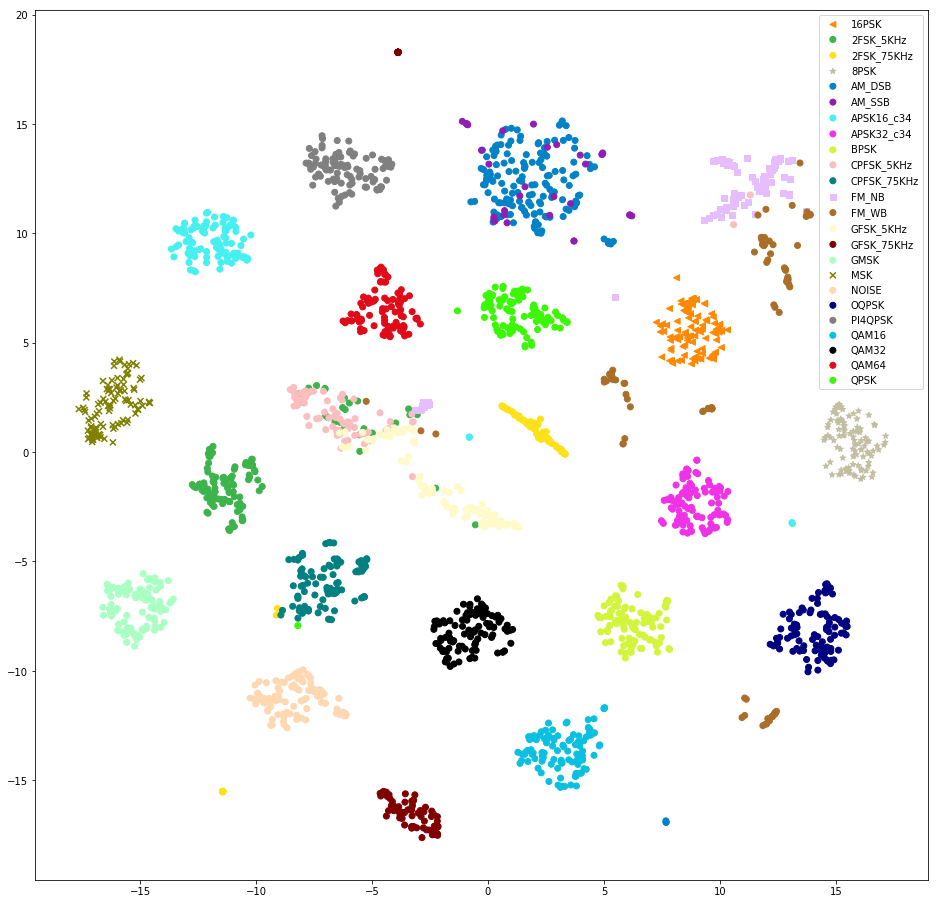

In [7]:
# using predictions for labels instead of ground truth
train_labels_predicted_probabilities = model.predict(train_data)
train_labels_predicted = np.asarray([CLASSES[np.argmax(pred)] for pred in train_labels_predicted_probabilities])
tsne_plus_plot(model, train_data, train_labels_predicted)

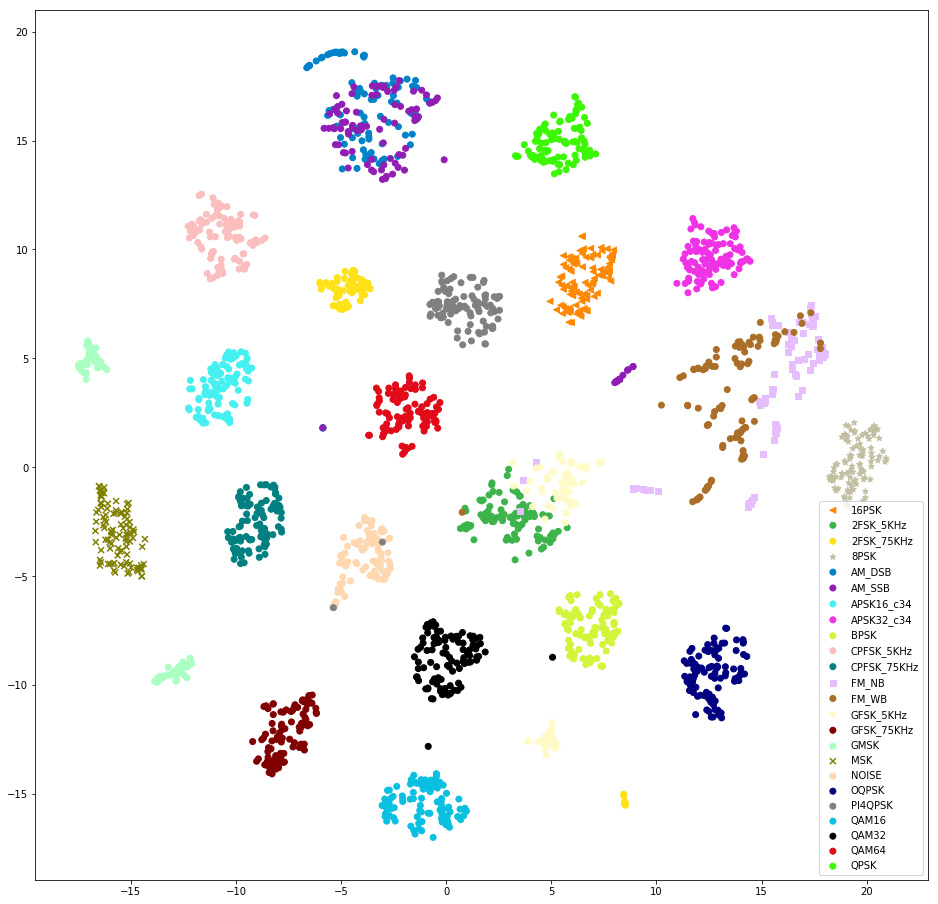

In [8]:
tsne_plus_plot(model, train_data2, train_labels2)

In [ ]:
#### Doing testset after filtering for high snr

In [9]:
snr_model = load_model("../../snr2.h5")

In [10]:
test_file = "../../Test_Set_1_Army_Signal_Challenge.pkl"
test_file2 = "../../Test_Set_2_Army_Signal_Challenge.pkl"


In [11]:
# open test sets
f = open(test_file, 'rb')
testdata1 = pickle.load(f, encoding='latin1')
testdata1 = np.stack([testdata1[i+1] for i in range(len(testdata1.keys()))], axis=0)

f = open(test_file2, 'rb')
testdata2 = pickle.load(f, encoding='latin1')
testdata2 = np.stack([testdata2[i+1] for i in range(len(testdata2.keys()))], axis=0)


In [12]:
# get snr preds
snr_preds1 = np.asarray([np.argmax(snr_prob) for snr_prob in snr_model.predict(testdata1)])
snr_preds2 = np.asarray([np.argmax(snr_prob) for snr_prob in snr_model.predict(testdata2)])

In [13]:
# filter testsets
testdata1  = testdata1[np.where(snr_preds1 == 5)]
testdata2  = testdata2[np.where(snr_preds2 == 5)]

In [14]:
testdata1  = testdata1[np.random.choice(testdata1.shape[0], 2400, replace=False)]
testdata2  = testdata2[np.random.choice(testdata2.shape[0], 2400, replace=False)]

In [15]:
test1_preds = model.predict(testdata1)
test2_preds = model.predict(testdata2)

In [16]:
test1_labels = np.asarray([CLASSES[np.argmax(pred)] for pred in test1_preds])
test2_labels = np.asarray([CLASSES[np.argmax(pred)] for pred in test2_preds])

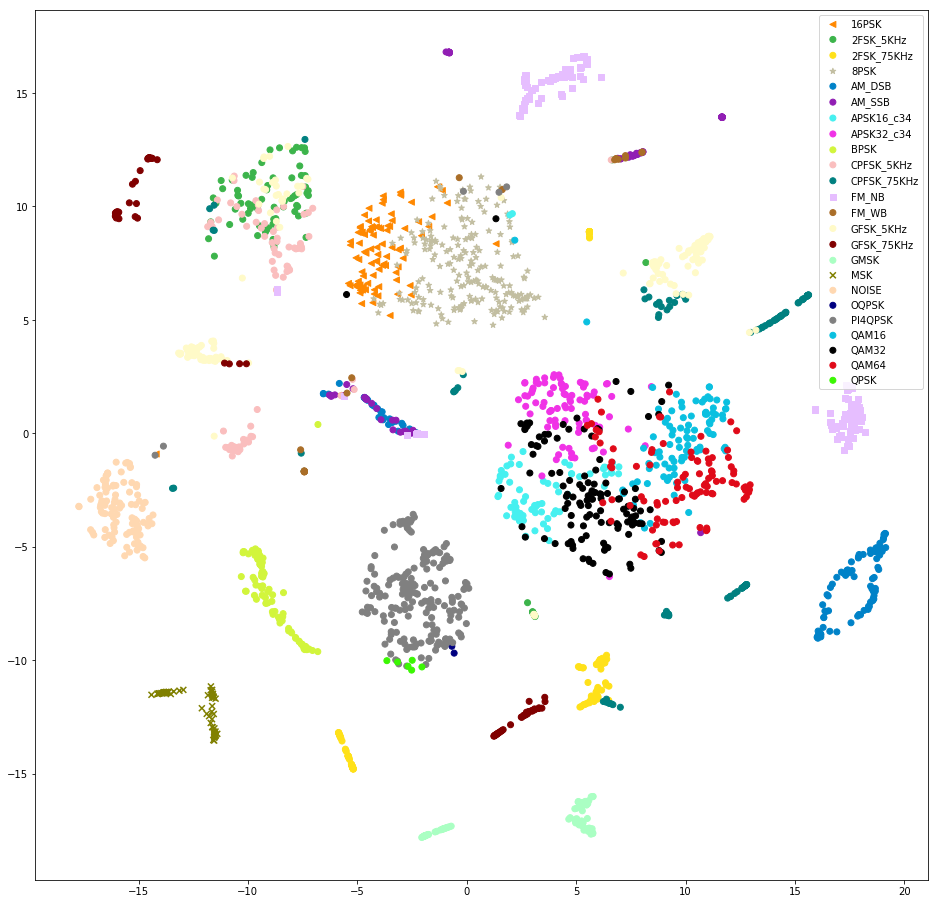

In [17]:
tsne_plus_plot(model, testdata1, test1_labels)

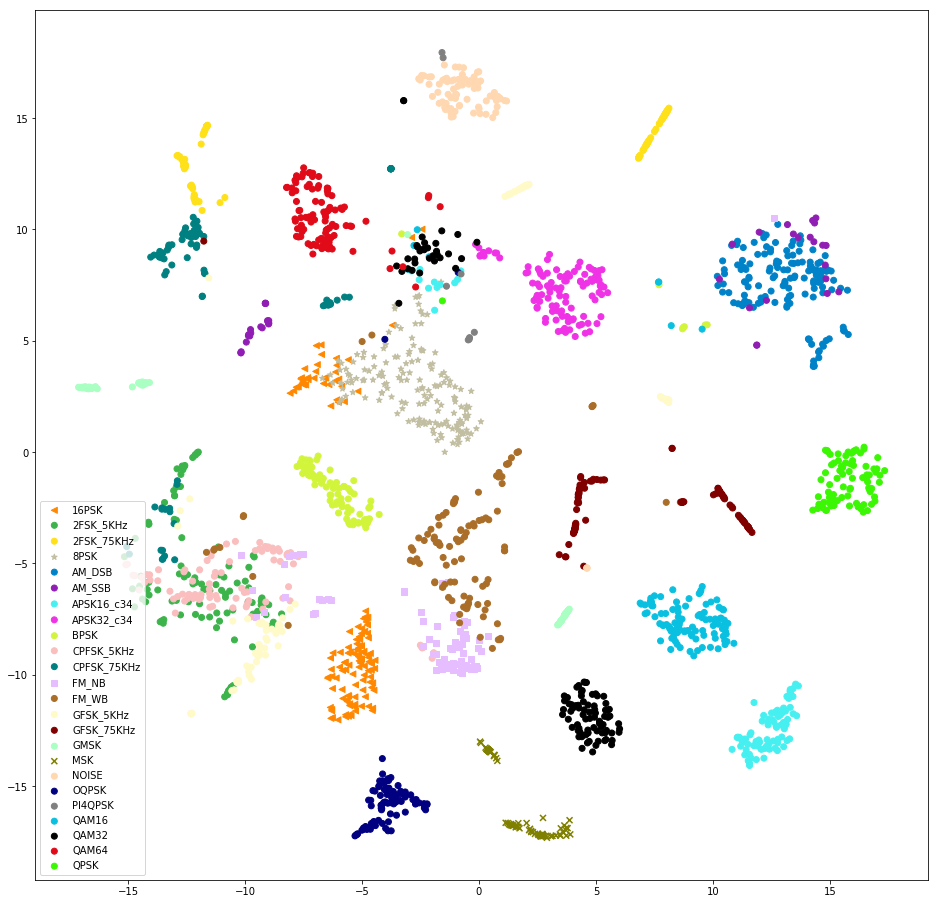

In [18]:
tsne_plus_plot(model, testdata2, test2_labels)

In [ ]:
### doing training set as if it was testset
### filter for snr and use preds as labels

In [29]:
data_file3 = "/datax/yzhang/training_data/training_data_chunk_10.pkl"

testdata3 = LoadModRecData(data_file3, 1., 0., 0.)
testdata3 = testdata3.signalData



[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [30]:
snr_preds3 = np.asarray([np.argmax(snr_prob) for snr_prob in snr_model.predict(testdata3)])

In [31]:
train_data3  = testdata3[np.where(snr_preds3 == 5)]

In [32]:
train_data3  = train_data3[np.random.choice(train_data3.shape[0], 2400, replace=False)]

In [34]:
train_labels3_probabilities = model.predict(train_data3)
train_labels3 = np.asarray([CLASSES[np.argmax(pred)] for pred in train_labels3_probabilities])

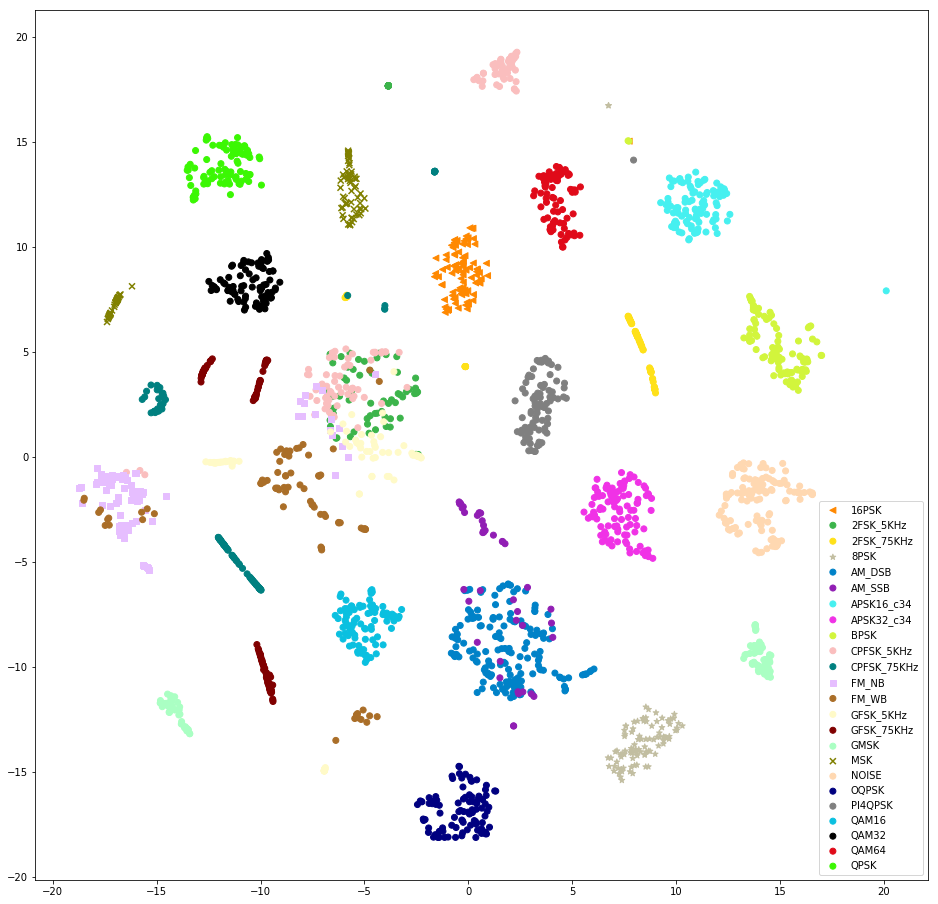

In [36]:
tsne_plus_plot(model, train_data3, train_labels3)

In [370]:
def open_test_file(f, filter_snr = True):
    # opens a testfile and if filter_snr is set to true then it will filter 
    # out only samples that have been predicted to have snr 10dB
    f = open(test_file, 'rb')
    testdata = pickle.load(f, encoding='latin1')
    testdata = np.asarray([testdata[i+1] for i in range(len(testdata.keys()))])
    if filter_snr:
        snr_probs = snr_model.predict(testdata)
        snr_preds = np.asarray([np.argmax(snr_prob) for snr_prob in snr_probs])
        return testdata[np.where(snr_preds == 5)]
    return testdata

def get_labels(model, data):
    # take data and predict label, returns int array; to get modulation of index i 
    # do CLASSES[res[i]]
    preds = model.predict(data)
    return np.asarray([np.argmax(pred) for pred in preds])

def get_mods_from_test_data(testdata1, testdata2, test1_labels, test2_labels, mod_indices, num_test_points=100):
    # gives us a specified number of data samples that we predict to be
    # of the specified modulation
    
    np.random.seed(0)
    batch, labels = [],[]
    for i in mod_indices:
        test1_filter = np.where(test1_labels == i)
        test2_filter = np.where(test2_labels == i)

        filtered1 = testdata1[test1_filter]
        filtered2 = testdata2[test2_filter]

        filtered1 = filtered1[np.random.choice(filtered1.shape[0], num_test_points, replace=False)]
        filtered2 = filtered2[np.random.choice(filtered2.shape[0], num_test_points, replace=False)]

        labels1 = [(CLASSES[i],1)]*num_test_points
        labels2 = [(CLASSES[i],2)]*num_test_points

        batch.append(filtered1)
        batch.append(filtered2)

        labels.extend(labels1)
        labels.extend(labels2)

    batch = np.concatenate(batch)
    labels = np.asarray(labels)
    return batch, labels

In [399]:
def plot_train_ts_mods(mod_indices, verbose = False, filtered_testdata = None, num_points = 200, num_test_points=100):
    # plots tsne of certain modulations of a training set and 2 testsets
    # num_points: # of points from training set
    # num_test_points: # of points from test set
    # Reading in training data
    
    data_file_5_mods = "/datax/yzhang/training_data/training_data_chunk_12.pkl"
    mods = [CLASSES[idx] for idx in mod_indices]
    testdata_5_LoadMod = LoadModRecData(data_file_5_mods, 1., 0., 0., load_snrs=[10], load_mods=mods, num_samples_per_key=num_points)
    testdata_5_mods = testdata_5_LoadMod.signalData
    testdata_5_labels = testdata_5_LoadMod.signalLabels[:,0]
    testdata_5_labels = np.asarray([(label, 0) for label in testdata_5_labels])
    
    if not filtered_testdata:
        # Read in test data and filter by snr
        test_file = "../../Test_Set_1_Army_Signal_Challenge.pkl"
        test_file2 = "../../Test_Set_2_Army_Signal_Challenge.pkl"

        if verbose:
            print("Opening Testfiles")
        testdata1 = open_test_file(test_file)
        testdata2 = open_test_file(test_file2)


        # get test labels
        if verbose:
            print("Predict Testlabels")
        test1_labels = get_labels(model, testdata1)
        test2_labels = get_labels(model, testdata2)
    else:
        testdata1,testdata2,test1_labels,test2_labels = filtered_testdata
    # get desired number of samples per mod per test set 
    batch, labels = get_mods_from_test_data(testdata1, testdata2, test1_labels, test2_labels, mod_indices, num_test_points=num_test_points)

    # combine train and test data
    batch = np.concatenate((testdata_5_mods, batch))
    labels = np.concatenate((testdata_5_labels, labels))

    
    # TSNE
    if verbose:
        print("TSNE")
    intermediates_tsne = tsne_model(model=model,data=batch)

    # Plotting
    labels_col1 = labels[:,0]
    labels_col2 = np.asarray(labels[:,1], dtype=int)
    
    if verbose:
        print("Plotting")
    plt.figure(figsize=(16,16))

    for i in range(3):
        if i == 0:
            marker = 'o'
        elif i == 1:
            marker = 'x'
        else:
            marker = 's'
        idx = np.where(labels_col2 == i)
        xaxis = intermediates_tsne[idx,0]
        yaxis = intermediates_tsne[idx,1]


        label_col = labels_col1[idx]

        for j in mod_indices:
            mod = CLASSES[j]
            idx1 = np.where(label_col == mod)                
            color = COLORS[mod]

    
            plt.scatter(x=xaxis[0,idx1],y=yaxis[0,idx1], color = color, marker=marker, label=mod+'_' + str(i))
    plt.legend()
    plt.show()

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 1000
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: QAM16
[Data Loader] - [Modulation Dataset] Adding Collects for: QAM32
[Data Loader] - [Modulation Dataset] Adding Collects for: QAM64
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 1000 Validation Size: 0 Test Size: 0
[Data Loader] - Done.

Opening Testfiles
Predict Testlabels
TSNE
Plotting


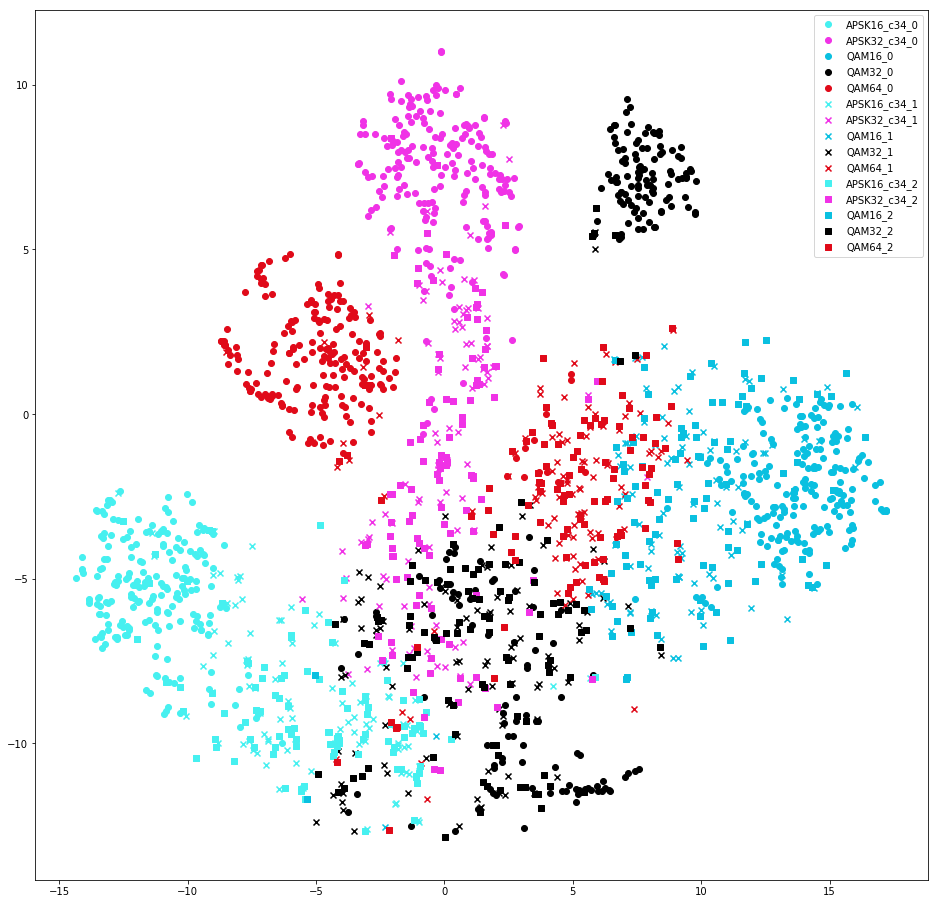

In [392]:
plot_train_ts_mods([6,7,20,21,22], verbose = True)

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 1000
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: QAM16
[Data Loader] - [Modulation Dataset] Adding Collects for: QAM32
[Data Loader] - [Modulation Dataset] Adding Collects for: QAM64
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 1000 Validation Size: 0 Test Size: 0
[Data Loader] - Done.

TSNE
Plotting


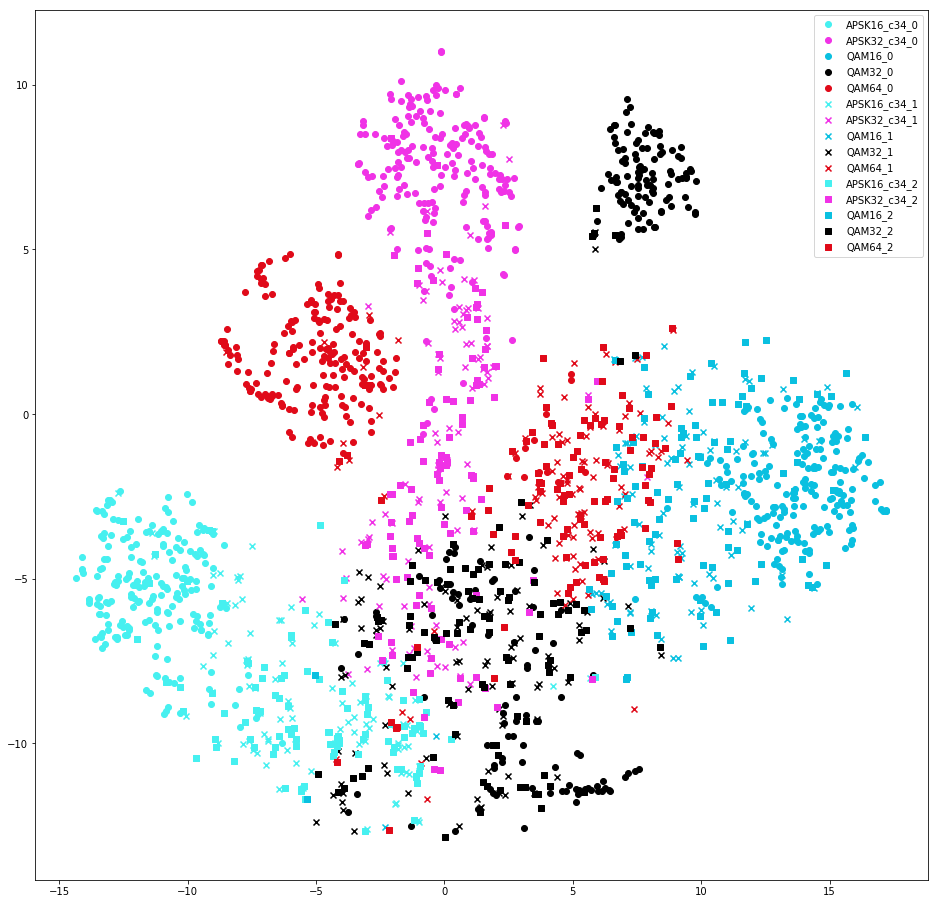

In [395]:
test_file = "../../Test_Set_1_Army_Signal_Challenge.pkl"
test_file2 = "../../Test_Set_2_Army_Signal_Challenge.pkl"
    
testdata1 = open_test_file(test_file)
testdata2 = open_test_file(test_file2)

test1_labels = get_labels(model, testdata1)
test2_labels = get_labels(model, testdata2)

plot_train_ts_mods([6,7,20,21,22], verbose = True, filtered_testdata = (testdata1,testdata2,test1_labels,test2_labels))

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 800
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 800 Validation Size: 0 Test Size: 0
[Data Loader] - Done.

TSNE
Plotting


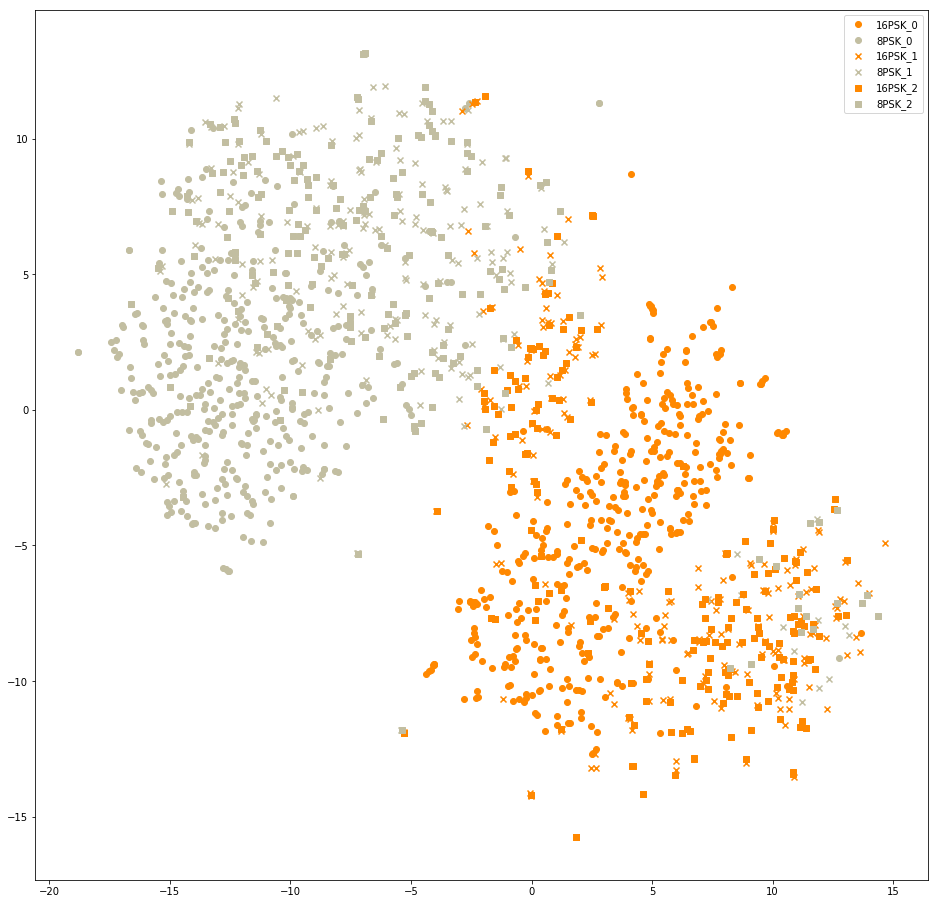

In [400]:
plot_train_ts_mods([0,3], verbose = True, filtered_testdata = (testdata1,testdata2,test1_labels,test2_labels), num_points=400, num_test_points=200)

In [421]:
data_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"

mod_idx = [0,2,5]
load_mods = [CLASSES[i] for i in mod_idx]

testdata = LoadModRecData(data_file, 1., 0., 0., load_snrs=[10], load_mods = load_mods, num_samples_per_key=300)
train_data = testdata.signalData
train_labels = testdata.signalLabels[:,0]


tsne = tsne_model(model=model,data=train_data)
# tsne_plus_plot(model,train_data,train_labels)

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 900
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 900 Validation Size: 0 Test Size: 0
[Data Loader] - Done.



In [467]:
BOOKEH_COLORS = {
    '16PSK': 'aqua', 
    '2FSK_5KHz': 'aquamarine', 
    '2FSK_75KHz': 'bisque', 
    '8PSK': 'black', 
    'AM_DSB': 'blue', 
    'AM_SSB':'blueviolet', 
    'APSK16_c34': 'brown',
    'APSK32_c34': 'burlywood', 
    'BPSK': 'cadetblue', 
    'CPFSK_5KHz': 'chartreuse', 
    'CPFSK_75KHz': 'chocolate', 
    'FM_NB': 'cornflowerblue', 
    'FM_WB': 'crimson',
    'GFSK_5KHz': 'darkcyan', 
    'GFSK_75KHz': 'darkgoldenrod', 
    'GMSK': 'darkgray', 
    'MSK': 'darkgreen', 
    'NOISE': 'darkorange', 
    'OQPSK': 'deeppink', 
    'PI4QPSK': 'fuchsia', 
    'QAM16': 'gold',
    'QAM32': 'lightblue', 
    'QAM64': 'magenta', 
    'QPSK': 'plum'}

BOOKEH_SHAPES = {
    '16PSK': 1, 
    '2FSK_5KHz': 2, 
    '2FSK_75KHz': 3, 
    '8PSK': 2, 
    'AM_DSB': 1, 
    'AM_SSB':2, 
    'APSK16_c34': 3,
    'APSK32_c34': 1, 
    'BPSK': 2, 
    'CPFSK_5KHz': 1, 
    'CPFSK_75KHz': 2, 
    'FM_NB': 3, 
    'FM_WB': 2,
    'GFSK_5KHz': 3, 
    'GFSK_75KHz': 2, 
    'GMSK': 1, 
    'MSK': 2, 
    'NOISE': 2, 
    'OQPSK': 1, 
    'PI4QPSK': 2, 
    'QAM16': 3,
    'QAM32': 1, 
    'QAM64': 2, 
    'QPSK': 3}

In [505]:
def separate_labels(tsne_output, labels):
    # splits tsne output and labels into subarrays that have the same labels
    unique_labels = np.unique(labels)
    
    tsne_subar = [0] * unique_labels.shape[0]
    label_subar = [0] * unique_labels.shape[0]
    indices = [0] * unique_labels.shape[0]
    for i,label in enumerate(unique_labels):
        idx = np.where(labels==label)
        
        tsne_subar[i] = tsne_output[idx]
        label_subar[i] = labels[idx]
        indices[i] = idx[0]
        
    return tsne_subar, label_subar, indices
        
        
        

In [510]:
tsne_sub, labels_sub, indices = separate_labels(tsne, train_labels)
print(indices[0].shape)
print(labels_sub[0][:10], indices[0][:10])

(300,)
['16PSK' '16PSK' '16PSK' '16PSK' '16PSK' '16PSK' '16PSK' '16PSK' '16PSK'
 '16PSK'] [ 2  3  7  8 10 11 14 22 23 25]


In [500]:
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool


In [511]:
output_notebook()

hover_tsne = HoverTool(tooltips = [("p", "(@x, @y)"),("label", "@label"),("index", "@index")]) 
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
p = figure(plot_width=600, plot_height=600, tools=tools_tsne)




Loading BokehJS ...

In [512]:
for i in range(len(tsne_sub)):
    tsne_ = tsne_sub[i]
    labels_ = labels_sub[i]
    indices_ = indices[i]
    labl = labels_[0]
    
    source_train = ColumnDataSource(
        data=dict(
            x = tsne_[:,0],
            y = tsne_[:,1],
            index = indices_,
            label = labels_
        )
    )
    
    
    shape = BOOKEH_SHAPES[labl]
    if shape == 1:
        p.circle('x', 'y', size=7, fill_color=BOOKEH_COLORS[labl], 
                 alpha=0.9, line_width=0, source=source_train, name="test")
    elif shape == 2:
        p.diamond('x', 'y', size=7, fill_color=BOOKEH_COLORS[labl], 
                 alpha=0.9, line_width=0, source=source_train, name="test")
    elif shape == 3:
        p.cross('x', 'y', size=7, fill_color=BOOKEH_COLORS[labl], 
                 alpha=0.9, line_width=0, source=source_train, name="test")
        
show(p)